In [1]:
import os
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import torchvision
from torchvision import transforms as T
import torch
from torch import nn
from utils import train_svm, compute_accuracy
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
class IrisDataset(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.image_path = []
        self.labels = []
        self.classes = os.listdir(root)

        for i, c in enumerate(self.classes):
            class_path = os.path.join(root, c)
            for img_name in os.listdir(class_path):
                self.image_path.append(os.path.join(class_path, img_name))
                self.labels.append(i)

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        img_path = self.image_path[idx]
        img = Image.open(img_path)
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [3]:
def load_iris(batch_size, train_transforms, val_transforms, test_transforms):
    full_dataset = IrisDataset(root='数据科学实践Data/LC-iris', transform=None)

    indices = list(range(len(full_dataset)))
    np.random.shuffle(indices)

    train_size = int(0.5 * len(full_dataset))
    val_size = int(0.3 * len(full_dataset))

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size+val_size]
    test_indices = indices[train_size+val_size:]

    train_dataset = Subset(IrisDataset(root='数据科学实践Data/LC-iris', transform=train_transforms), train_indices)
    val_dataset = Subset(IrisDataset(root='数据科学实践Data/LC-iris', transform=val_transforms), val_indices)
    test_dataset = Subset(IrisDataset(root='数据科学实践Data/LC-iris', transform=test_transforms), test_indices)

    train_iter = DataLoader(train_dataset, batch_size, shuffle=True)
    val_iter = DataLoader(val_dataset, batch_size, shuffle=False)
    test_iter = DataLoader(test_dataset, batch_size, shuffle=False)
    return train_iter, val_iter, test_iter

In [4]:
train_trans = T.Compose([T.ToTensor()])
train_iter, val_iter, test_iter = load_iris(63, train_trans, train_trans, train_trans)

In [5]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 256 * 256, 3)
)
num_epochs, lr, weight_decay = 50, 0.002, 0.01
train_loss, val_loss, train_acc, val_acc, net = train_svm(num_epochs, net, lr, weight_decay, train_iter, val_iter)

train_acc: 0.9683, val_acc: 0.5476: 100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


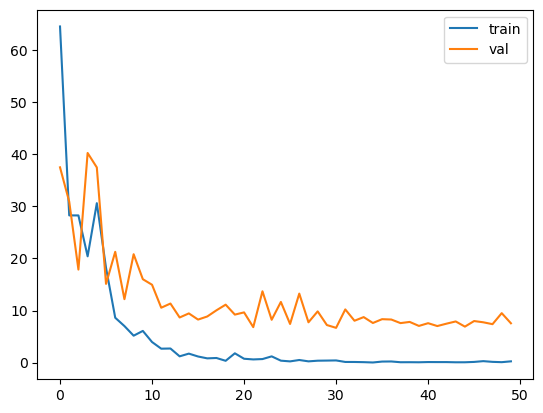

In [6]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

In [7]:
[i for i in net.parameters()]

[Parameter containing:
 tensor([[-0.0017,  0.0008,  0.0004,  ..., -0.0039, -0.0048, -0.0032],
         [ 0.0006, -0.0006, -0.0039,  ...,  0.0041,  0.0045,  0.0073],
         [ 0.0016,  0.0050,  0.0075,  ..., -0.0003, -0.0042, -0.0063]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0049,  0.0057, -0.0024], requires_grad=True)]

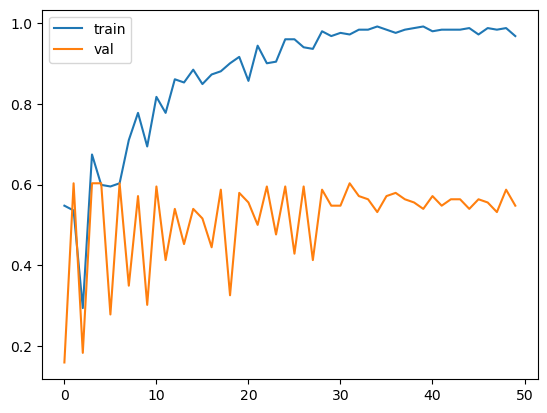

In [8]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

In [9]:
lr_list = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 256 * 256, 3)
)
num_epochs, weight_decay = 50, 0.01


In [10]:
div = {}
for lr in lr_list:
    train_loss, val_loss, train_acc, val_acc, net = train_svm(num_epochs, net, lr, weight_decay, train_iter, val_iter)
    div[lr] = [val_acc[-1], net]

train_acc: 0.9841, val_acc: 0.5714: 100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


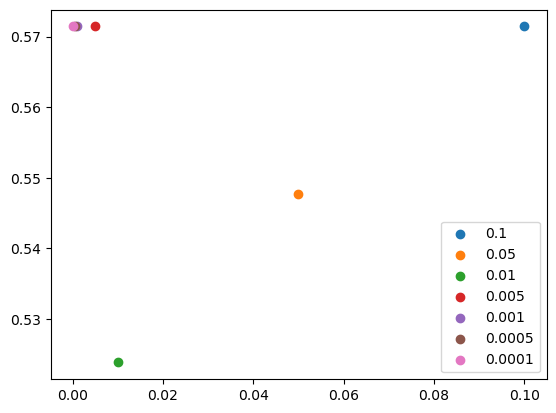

In [11]:
for lr in lr_list:
    plt.scatter(lr, div[lr][0], label=lr)
plt.legend()
plt.show()

In [12]:
net = div[0.01][1]
test_acc = 0
for X, y in test_iter:
    test_acc += compute_accuracy(net, X, y)
test_acc /= len(test_iter)
print(test_acc)

0.5266955494880676


# O

In [13]:
train_trans = T.Compose([T.RandomCrop(224), 
                         T.RandomHorizontalFlip(),
                         #T.RandomRotation(10),
                         T.ToTensor(),
                         T.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])])
val_trans = T.Compose([T.Resize(224),
                          T.ToTensor(),
                          T.Normalize(mean=[0.485, 0.456, 0.406], 
                                      std=[0.229, 0.224, 0.225])])
test_trans = T.Compose([
                        T.TenCrop(224),
                        T.Lambda(lambda crops: torch.stack([
                            T.Compose([
                                T.ToTensor(),  
                                T.Normalize(mean=[0.485, 0.456, 0.406],                                              
                                            std=[0.229, 0.224, 0.225])
                            ])(crop) for crop in crops]))])

                    
train_iter, val_iter, test_iter = load_iris(63, train_trans, val_trans, test_trans)

In [14]:
def train_svm_(num_epochs, net, lr, weight_decay, train_iter, val_iter): 
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, cooldown=5)
    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    with tqdm(total=num_epochs) as pbar:
        for _ in range(num_epochs):
            train_l, train_a = 0, 0
            for X, y in train_iter:
                optimizer.zero_grad()
                y_hat = net(X)
                l = loss(y_hat, y)
                l.backward()
                optimizer.step()
                train_l += l.item()
                train_a += compute_accuracy(net, X, y)
            train_loss.append(train_l / len(train_iter))
            train_acc.append(train_a / len(train_iter))
            val_l, val_a = 0, 0
            with torch.no_grad():
                for X, y in val_iter:
                    y_hat = net(X)
                    l = loss(y_hat, y)
                    val_l += l.item()
                    val_a += compute_accuracy(net, X, y)
                val_loss.append(val_l / len(val_iter))
                val_acc.append(val_a / len(val_iter))
            scheduler.step(val_loss[-1])
            pbar.set_description(f"train_acc: {train_acc[-1]:.4f}, val_acc: {val_acc[-1]:.4f}")
            pbar.update()
    return train_loss, val_loss, train_acc, val_acc, net


In [ ]:
net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
net.fc = nn.Linear(512, 3)
num_epochs, lr, weight_decay = 50, 0.01, 0.0001
train_loss, val_loss, train_acc, val_acc, net = train_svm_(num_epochs, net, lr, weight_decay, train_iter, val_iter)

train_acc: 0.6230, val_acc: 0.6270:  58%|█████▊    | 29/50 [09:08<06:39, 19.00s/it]

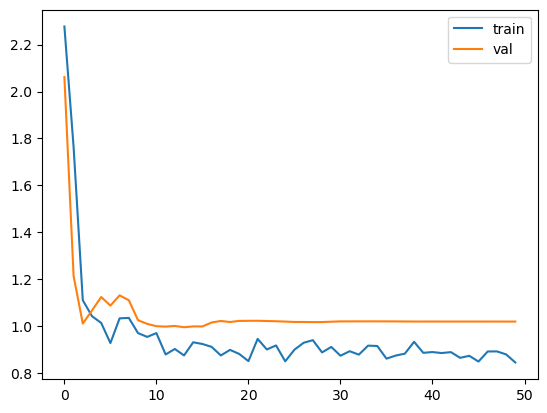

In [ ]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

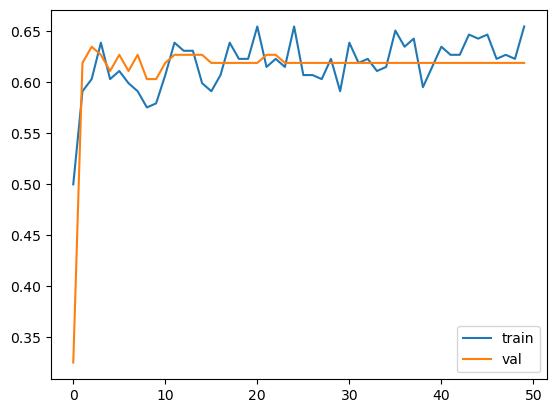

In [ ]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()